**Data aquisition**

The datasets metadata.csv and electricity_cleaned are both datasets from kaggle

In [11]:
import pandas as pd
from pathlib import Path

RAW = Path('../../data/raw')

elec_path = RAW / 'electricity_cleaned.csv'
meta_path = RAW / 'metadata.csv'

electricity = pd.read_csv('electricity_cleaned.csv')
metadata   = pd.read_csv('metadata.csv')

print(electricity.shape, metadata.shape)
print(electricity.columns[:10])
print(metadata[['building_id','yearbuilt','sqft','primaryspaceusage']].head())


(17544, 1579) (1636, 32)
Index(['timestamp', 'Panther_parking_Lorriane', 'Panther_lodging_Cora',
       'Panther_office_Hannah', 'Panther_lodging_Hattie',
       'Panther_education_Teofila', 'Panther_education_Jerome',
       'Panther_retail_Felix', 'Panther_parking_Asia',
       'Panther_education_Misty'],
      dtype='object')
                 building_id  yearbuilt     sqft    primaryspaceusage
0       Panther_lodging_Dean     1989.0   5477.0  Lodging/residential
1     Panther_lodging_Shelia     1992.0  10000.0  Lodging/residential
2      Panther_lodging_Ricky     2016.0   5200.0  Lodging/residential
3  Panther_education_Rosalie     2008.0   7432.0            Education
4    Panther_education_Misty     2004.0   2720.0            Education


In [73]:
# electricity has: timestamp + many building columns
id_col = 'timestamp'
value_name = 'usage_kwh'

# Melt to long format: one row per (timestamp, building_id)
elec_long = electricity.melt(
    id_vars=[id_col],
    var_name='building_id',
    value_name=value_name
)

# Make sure usage is numeric (coerce non-numeric to NaN)
elec_long[value_name] = pd.to_numeric(elec_long[value_name], errors='coerce')

print(elec_long.head())
print(elec_long.shape)


             timestamp               building_id  usage_kwh
0  2016-01-01 00:00:00  Panther_parking_Lorriane        NaN
1  2016-01-01 01:00:00  Panther_parking_Lorriane        NaN
2  2016-01-01 02:00:00  Panther_parking_Lorriane        NaN
3  2016-01-01 03:00:00  Panther_parking_Lorriane        NaN
4  2016-01-01 04:00:00  Panther_parking_Lorriane        NaN
(27684432, 3)


Some information we know about the size of the dataset is given above and from the head we can see the headers consists of timestamps, building id and electricity usage(usage_kwh)

In [75]:
# Mean usage per building (you could also use .sum() or .median())
usage_summary = (
    elec_long
    .dropna(subset=[value_name])
    .groupby('building_id', as_index=False)[value_name]
    .mean()
    .rename(columns={value_name: 'avg_usage_kwh'})
)

usage_summary.head()


,building_id,avg_usage_kwh
0,Bear_assembly_Angel,494.336396
1,Bear_assembly_Beatrice,42.962056
2,Bear_assembly_Danial,160.655729
3,Bear_assembly_Diana,0.856884
4,Bear_assembly_Genia,261.089054


In [77]:
AS_OF_YEAR = 2025

if 'age' not in metadata.columns:
    if 'yearbuilt' in metadata.columns:
        metadata['age'] = AS_OF_YEAR - pd.to_numeric(metadata['yearbuilt'], errors='coerce')
    else:
        raise ValueError("metadata.csv needs 'age' or 'yearbuilt' to compute building age.")

merged = metadata.merge(usage_summary, on='building_id', how='inner')

print(merged.shape)
merged[['building_id','age','sqft','primaryspaceusage','avg_usage_kwh']].head()


(1572, 34)


,building_id,age,sqft,primaryspaceusage,avg_usage_kwh
0,Panther_education_Rosalie,17.0,7432.0,Education,64.977761
1,Panther_education_Misty,21.0,2720.0,Education,33.433645
2,Panther_education_Mattie,34.0,5376.0,Education,6.687316
3,Panther_education_Diann,23.0,23685.0,Education,89.617149
4,Panther_education_Gina,50.0,116607.0,Education,417.137948


In [79]:
merged[['age','avg_usage_kwh']].describe()
merged.isna().sum().sort_values(ascending=False).head(10)


solar              1567
leed_level         1559
irrigation         1555
date_opened        1553
water              1448
site_eui           1423
source_eui         1423
energystarscore    1423
gas                1401
rating             1389
dtype: int64

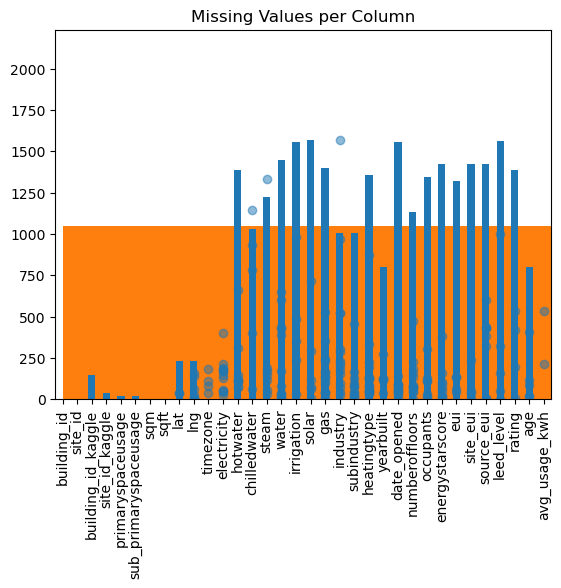

In [89]:
plt.hist(merged['age'].dropna(), bins=30)
plt.title('Distribution of Building Age')
plt.savefig('../../figures/age_distribution.png')

plt.hist(merged['avg_usage_kwh'].dropna(), bins=30)
plt.title('Distribution of Avg Electricity Usage')
plt.savefig('../../figures/usage_distribution.png')

plt.scatter(merged['age'], merged['avg_usage_kwh'], alpha=0.5)
plt.title('Age vs. Electricity Usage')
plt.savefig('../../figures/age_vs_usage_scatter.png')

merged.isna().sum().plot(kind='bar')
plt.title('Missing Values per Column')
plt.savefig('../../figures/missingness_bar.png')


wecan see the amount of missing data from the datasets, which for building id we dont have any and we have a certain amkount for electriciy, that may change the way we approach our way of visualising and understanding the data

**Baseline Model**

In [95]:
import numpy as np, math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

work = merged.dropna(subset=['age','avg_usage_kwh']).copy()

X = work[['age']].values
y = work['avg_usage_kwh'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Baseline 1: mean predictor
y_pred_mean = np.full_like(y_test, y_train.mean(), dtype=float)
print("Mean predictor:",
      "MAE=", round(mean_absolute_error(y_test, y_pred_mean), 3),
      "RMSE=", round(math.sqrt(mean_squared_error(y_test, y_pred_mean)), 3),
      "R^2=", round(r2_score(y_test, y_pred_mean), 3))

# Baseline 2: linear regression on age
lin = LinearRegression().fit(X_train, y_train)
y_pred_lr = lin.predict(X_test)

print("Linear regression(age):",
      "MAE=", round(mean_absolute_error(y_test, y_pred_lr), 3),
      "RMSE=", round(math.sqrt(mean_squared_error(y_test, y_pred_lr)), 3),
      "R^2=", round(r2_score(y_test, y_pred_lr), 3),
      "| coef(age)=", round(lin.coef_[0], 6),
      "intercept=", round(lin.intercept_, 3))


Mean predictor: MAE= 129.861 RMSE= 192.703 R^2= -0.001
Linear regression(age): MAE= 125.249 RMSE= 192.36 R^2= 0.003 | coef(age)= -1.219795 intercept= 207.477


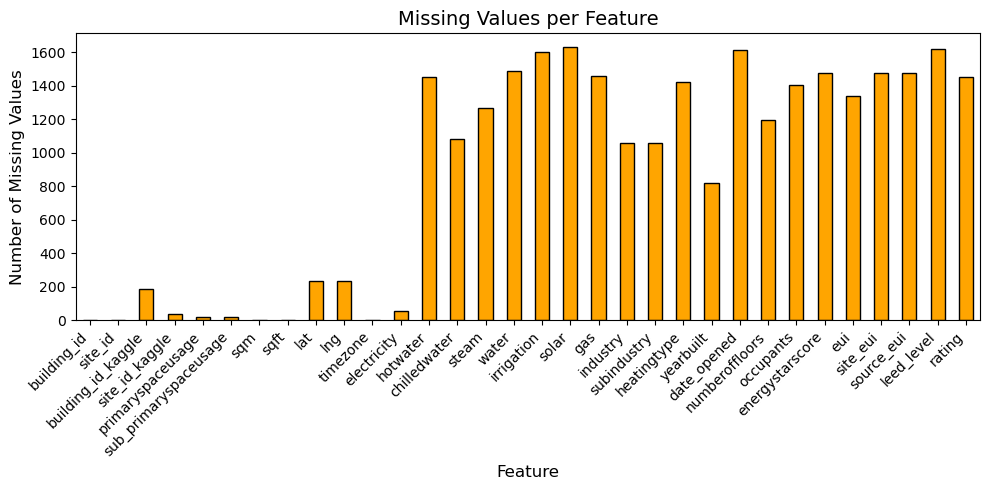

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace "df" with the name of your dataset variable if different
missing_counts = metadata.isnull().sum()

plt.figure(figsize=(10, 5))
missing_counts.plot(kind='bar', color='orange', edgecolor='black')

plt.title("Missing Values per Feature", fontsize=14)
plt.ylabel("Number of Missing Values", fontsize=12)
plt.xlabel("Feature", fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("missingness_bar.png", dpi=300)
plt.show()
